In [1]:
# Cell 1: Imports and Data Loading
import numpy as np
import scipy.io as sio
# import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from types import SimpleNamespace

# --- Load DP results from .mat file ---
data = sio.loadmat('dp_results_for_plant.mat', squeeze_me=True)

# --- Extract Raw Drive Cycle Inputs & State Variables ---
# These will form our 9D observation space
speed         = data['Speed'].flatten()
temp          = data['BAT_temp'].flatten()
power_req     = data['PowerReq'].flatten() * 1000  # [W]
gear          = data['Gear'].flatten().astype(float)
soc           = data['SOC'].flatten()
q_sei         = data['Q_SEI'].flatten()
EM_temp       = data['EM_temp'].flatten()
switch_count  = data['switch_count'].flatten()
Eng_on_status = data['Eng_on_status'].flatten()

# --- Assemble the 9D Raw Observation Array ---
# This combines all input and state variables into one array before any normalization.
raw_obs = np.vstack([
    speed, temp, power_req, gear, soc, q_sei, EM_temp, switch_count, Eng_on_status
]).T.astype(np.float32)

# --- Assemble the 2D Expert Action Array for Behavior Cloning ---
# Actions are [normalized power, engine on/off label]
# This part remains the same as it correctly formats the target actions into the [0, 1] range.
power_eng      = data['Pow_eng'].flatten() * 1000  # [W]
curr_engine_on = data['curr_engine_on'].flatten()

N_PowerEng = float(np.squeeze(data['f_PowerEng'])) * 1000
N_curr_engine_on = np.max(curr_engine_on) if np.max(curr_engine_on) > 0 else 1.0

col1 = (power_eng / N_PowerEng).reshape(-1, 1).astype(np.float32)
col2 = (curr_engine_on / N_curr_engine_on).reshape(-1, 1).astype(np.float32)
dp_actions_new = np.hstack([col1, col2])


# --- Factors needed for de-normalization inside the Plant Model ---
# These are passed to the environment so it can correctly run the simulator.
N_power = np.max(np.abs(power_req))
gear_min, gear_max = gear.min(), gear.max()
N_gear = (gear_min, gear_max) # Pass as a tuple

# --- Verification Print ---
print("✅ Cell 1 executed successfully.")
print(f"Shape of raw_obs: {raw_obs.shape}")
print(f"Shape of dp_actions_new: {dp_actions_new.shape}")
print("\nExpert Action (Engine Power) Range:", f"{dp_actions_new[:, 0].min():.4f} to {dp_actions_new[:, 0].max():.4f}")
print("Expert Action (Engine On/Off) Range:", f"{dp_actions_new[:, 1].min():.4f} to {dp_actions_new[:, 1].max():.4f}")

✅ Cell 1 executed successfully.
Shape of raw_obs: (3606, 9)
Shape of dp_actions_new: (3606, 2)

Expert Action (Engine Power) Range: 0.0000 to 0.9021
Expert Action (Engine On/Off) Range: 0.0000 to 1.0000


In [2]:
# import torch

# # Check if CUDA (GPU support) is available
# print("CUDA available:", torch.cuda.is_available())

# # If available, get the GPU name
# if torch.cuda.is_available():
#     print("Number of GPUs:", torch.cuda.device_count())
#     print("Current GPU device index:", torch.cuda.current_device())
#     print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))


In [3]:
# Cell 2: Calculate Standardization Statistics & Prepare Training Data

# --- Define PyTorch Device ---
# This will be used for all models and tensors in later cells.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# --- Calculate Mean and Standard Deviation from Raw Data ---
# These statistics will be used to standardize all future observations.
OBS_MEAN = np.mean(raw_obs, axis=0)
OBS_STD  = np.std(raw_obs, axis=0)

# --- Add a small epsilon to STD to prevent division by zero ---
# This is a standard safety measure for features that might be constant.
OBS_STD[OBS_STD < 1e-8] = 1e-8

# --- Standardize the observations for Behavior Cloning ---
# This becomes the input data for our pre-training.
warm_obs_std = (raw_obs - OBS_MEAN) / OBS_STD

# --- Verification Print ---
print("\n✅ Cell 2 executed successfully.")
print(f"Shape of standardized warm_obs_std: {warm_obs_std.shape}")

print("\nCalculated Observation Mean (OBS_MEAN):")
print(OBS_MEAN)
print("\nCalculated Observation Std Dev (OBS_STD):")
print(OBS_STD)


✅ Cell 2 executed successfully.
Shape of standardized warm_obs_std: (3606, 9)

Calculated Observation Mean (OBS_MEAN):
[1.1625055e+01 2.9814996e+02 5.0189773e+04 2.4750416e+00 5.4857147e-01
 1.3385061e-07 8.6785927e+01 8.2057679e-01 8.2057679e-01]

Calculated Observation Std Dev (OBS_STD):
[1.0944169e+01 3.0517578e-05 5.6934699e+04 1.4336164e+00 1.2131735e-03
 7.7257198e-08 2.8174744e+01 3.8370627e-01 3.8370627e-01]


In [4]:
# Cell 3: Plant and Environment Definitions

import gym
from gym import spaces
from scipy.interpolate import interp1d, RegularGridInterpolator
import math
from numpy.lib import scimath
from types import SimpleNamespace
from find_best_engine_operating_point_vectorized import find_best_engine_operating_point_vectorized

# =====================================================================================
#  HEVSimulator Class
# =====================================================================================
class HEVSimulator:
    def __init__(self, param_file, drive_file):
        # Load parameters & drive cycle
        self.params = sio.loadmat(param_file, squeeze_me=True, struct_as_record=False)
        self.drive  = sio.loadmat(drive_file,  squeeze_me=True, struct_as_record=False)
        # Drive
        self.v    = self.drive['speed_vector'].squeeze()
        self.a    = self.drive['acceleration_vector'].squeeze()
        self.grad = self.drive['elevation_vector'].squeeze()
        self.N    = len(self.v)
        # Components
        p = self.params
        self.BAT, self.ENG, self.GEN, self.MOT, self.TRAN, self.ENV, self.VEH = (
            p['BAT_LFP'], p['ENG'], p['GEN'], p['MOT'], p['TRAN'], p['ENV'], p['VEH']
        )

        # Upscaling motor
        scale = 1.0
        self.MOT.Tm_list      = (np.array(self.MOT.Tm_list,      dtype=np.float64) * scale)
        self.MOT.Tmmax        = (np.array(self.MOT.Tmmax,        dtype=np.float64) * scale)
        self.MOT.Tmmin        = (np.array(self.MOT.Tmmin,        dtype=np.float64) * scale)
        self.MOT.Tmmax_maxlim = (np.array(self.MOT.Tmmax_maxlim, dtype=np.float64) * scale)
        self.MOT.Tmmax_coeff  = (np.array(self.MOT.Tmmax_coeff,  dtype=np.float64) * scale)

        # Fuel map array
        try:
            self.ENG.mf = np.array(self.ENG.mf, dtype=float)
        except:
            self.ENG.mf = np.array([float(x) for x in self.ENG.mf])

        # Battery temp
        self.BAT.temp = 25
        self.T_K      = self.BAT.temp + 273.15

        # Sim params
        self.Ts = 1.0
        self.lambda_penalty = 1

        # Aging constants
        self.lemda = -1.6027
        self.k_SEI = 3.7249e-06
        self.E_SEI = -83.6171
        self.k_AM  = 3.5e-08
        self.E_AM  = 5.0e-08
        self.R_val = 8.314
        self.theta = 6.7872e-06
        self.i0    = 0.05

        # Q_SEI_0 (internal baseline)
        self.Q_SEI_0 = (
            (self.k_SEI * math.exp(-self.E_SEI / (self.R_val * self.T_K)))**2 /
            ((2 * (1 + self.lemda * self.theta))**2 * self.i0)
        )

        # Vehicle/env constants
        self.r   = float(self.VEH.r)
        self.rho = float(self.ENV.rho)
        self.Af  = float(self.VEH.Af)
        self.Cd  = float(self.VEH.Cd)
        self.Cr  = float(self.VEH.Cr)
        self.M   = float(self.VEH.M)
        self.Mv  = float(self.VEH.Mv)
        self.g   = float(self.ENV.g)

        # Interpolants (motor)
        max_wm_list = np.array(self.MOT.max_wm_list).flatten()
        min_wm_list = np.array(self.MOT.min_wm_list).flatten()
        wm_list     = np.array(self.MOT.wm_list).flatten()
        Tmmax       = np.array(self.MOT.Tmmax).flatten()
        Tmmin       = np.array(self.MOT.Tmmin).flatten()
        Tm_list     = np.array(self.MOT.Tm_list).flatten()
        etam        = np.array(self.MOT.etam)

        self.interp_Tmmax = interp1d(max_wm_list, Tmmax, kind='linear', fill_value="extrapolate")
        self.interp_Tmmin = interp1d(min_wm_list, Tmmin, kind='linear', fill_value="extrapolate")

        # Note: we use a fresh RegularGridInterpolator later with (wm_list, Tm_list) ordering
        self.interp_eff = RegularGridInterpolator((Tm_list, wm_list), etam.T,
                                                  method='linear', bounds_error=False)

        # Interpolants (engine fuel)
        Torq_rng  = np.array(self.ENG.Torq_range).flatten()
        speed_rng = np.array(self.ENG.speed_range).flatten()
        self.interp_fuel = RegularGridInterpolator((Torq_rng, speed_rng), self.ENG.mf.T,
                                                   method='linear', bounds_error=False)

        # Battery R tables
        temp_list = np.array(self.BAT.temp_list).flatten()
        soc_list  = np.array(self.BAT.soc_list).flatten()
        R_dis_tab = np.array(self.BAT.battery_soc_Rdis)
        R_chg_tab = np.array(self.BAT.battery_soc_Rchg)
        self.r_dis_interp = RegularGridInterpolator((temp_list, soc_list), R_dis_tab.T,
                                                    method='linear', bounds_error=False)
        self.r_chg_interp = RegularGridInterpolator((temp_list, soc_list), R_chg_tab.T,
                                                    method='linear', bounds_error=False)

        self.on_threshold      = 0.10
        self.penalty_threshold = 1.0
        self.penalty_hard      = 1.0

        # --- Accumulator for offset-free Q_SEI built from dQ_SEI (for export only) ---
        self.Q_SEI_rel = 0.0

    def evaluate_step(self, k, SOC_k, Q_SEI_k, Gen_age_k, switch_c_k,
                      eng_on_off_k, engine_power_norm, eng_on_off_cont,
                      gear, power_req):

        Q_AM_k = 0.0

        threshold_violation = False
        if 0.0 < engine_power_norm < self.on_threshold:
            threshold_violation = True

        v    = self.v[k]
        a    = self.a[k]
        grad = self.grad[k]

        # Denormalize gear from [0,1] to [gear_min, gear_max]
        gear_min, gear_max = N_gear
        gear = np.round(
            gear * (gear_max - gear_min) + gear_min
        ).astype(int)

        r_gear = np.array(self.TRAN.r_gear).flatten()
        ita    = float(self.TRAN.gb_effi)
        rg     = r_gear[int(gear) - 1]

        wv  = v / self.r
        dwv = a / self.r
        wg  = rg * wv
        dwg = rg * dwv

        max_wm = float(self.MOT.wm_list[-1])
        overspeed_violation = False
        if wg > max_wm:
            overspeed_violation = True

        Tm_max = self.interp_Tmmax(wg)
        Tm_min = self.interp_Tmmin(wg)

        T_motor = power_req / wg if wg > 0.0 else 0.0
        T_motor = np.clip(T_motor, Tm_min, Tm_max)

        # Motor efficiency from map (wm_list, Tm_list)
        Tm_list = np.array(self.MOT.Tm_list).flatten()
        wm_list = np.array(self.MOT.wm_list).flatten()
        etam    = np.array(self.MOT.etam)

        eff_interp = RegularGridInterpolator((wm_list, Tm_list), etam,
                                             bounds_error=False, fill_value=1.0)
        Tm_clipped = np.clip(abs(T_motor), Tm_list.min(), Tm_list.max())
        wg_clipped = np.clip(wg,         wm_list.min(), wm_list.max())
        e_m        = eff_interp([[wg_clipped, Tm_clipped]])[0]

        # Motor drag
        Tm0          = 0.0
        P_drag_motor = wg * Tm0
        P_Aux        = 5000.0

        if T_motor >= 0:
            P_motor_effective = (T_motor * wg + P_drag_motor) / e_m
        else:
            P_motor_effective = (T_motor * wg + P_drag_motor) * e_m

        # Engine power command (normalized → W)
        P_engine_raw = engine_power_norm * N_PowerEng

        # Engine drag
        Te0        = 0.0
        P_drag_eng = wg * Te0
        P_drag_eng = 0.0
        P_engine   = max(P_engine_raw - P_drag_eng, 0.0)

        # Engine ON/OFF & switch count
        curr_engine_on  = eng_on_off_cont
        prev_engine_on  = eng_on_off_k
        engine_switch   = abs(curr_engine_on - prev_engine_on)
        switch_c_next   = switch_c_k + engine_switch
        eng_on_off_next = curr_engine_on

        Te_min_valid = np.min(np.array(self.ENG.Torq_range)[np.array(self.ENG.Torq_range) > 0])
        we_min_valid = max(self.ENG.we_idle, np.min(np.array(self.ENG.speed_range)))
        P_engine_min = Te_min_valid * we_min_valid

        bad_combo = (curr_engine_on == 0) & (P_engine > 0)

        if curr_engine_on == 0:
            we          = 0.0
            Te          = 0.0
            mf_out      = 0.0
            Peng_out    = 0.0
            Pgen_out    = 0.0
            gen_eff_out = 0.0
            P_engine    = 0.0
            Pgen        = 0.0
            Pgen_loss   = 0.0
        else:
            Peng_unique = P_engine
            we_table, Te_table, mf_table, Peng_table, Pgen_table, gen_eff_table = \
                find_best_engine_operating_point_vectorized(self.ENG, self.GEN, Peng_unique, 0)

            if Peng_table.ndim > 0 and Peng_table.size > 0:
                idx_map = np.argmin(np.abs(Peng_table - Peng_unique))
            else:
                idx_map = 0

            we          = we_table[idx_map]
            Te          = Te_table[idx_map]
            mf_out      = mf_table[idx_map]
            Peng_out    = Peng_table[idx_map]
            Pgen_out    = Pgen_table[idx_map]
            gen_eff_out = gen_eff_table[idx_map]

            P_engine = Peng_out
            Pgen     = Pgen_out

            if Pgen_out > 0 and gen_eff_out > 0:
                Pgen_loss = ((1.0 / gen_eff_out) - 1.0) * Pgen_out
            else:
                Pgen_loss = 0.0

        # EM thermal / aging
        mc_int_temp = 40.0
        mc_amb_tmp  = 40.0
        mc_mass     = 195.0
        mc_cp       = 430.0
        mc_r        = 0.270
        mc_h        = 0.607
        mc_area     = 2 * np.pi * mc_r * mc_h + 2 * np.pi * mc_r**2

        L_0     = 20000.0 * 3600.0
        TI      = 105.0
        HIC     = 10.0
        theta_c = 105.0

        L_theta_c = L_0 * 2 ** ((TI - theta_c) / HIC)

        co_amb_tmp = 80.0
        co_wet_A   = 0.05
        co_h       = 1000.0

        ha = 6 + 6 * ((np.abs(mc_amb_tmp - Gen_age_k) / 1000.0) ** 0.25) + \
             60 * ((np.abs(0.5 * v) / 30.0) ** 0.63)

        Qa  = ha * mc_area * (mc_amb_tmp - Gen_age_k)
        Qr  = 0.9 * 5.67e-08 * mc_area * ((mc_amb_tmp + 273.0)**4 - (Gen_age_k + 273.0)**4)
        Qco = co_wet_A * co_h * (co_amb_tmp - Gen_age_k)

        Gen_age_next = Gen_age_k + (Pgen_loss + Qa + Qr + Qco) / (mc_mass * mc_cp) * self.Ts
        dT_Gen       = (Gen_age_next - Gen_age_k) / self.Ts

        if Gen_age_next >= TI:
            d_l_1_2 = (2 ** ((Gen_age_next - TI) / HIC)) / L_0
        else:
            d_l_1_2 = 0.0

        penalty_low_demand = 0.0

        # Power flow (series hybrid)
        if P_motor_effective >= -0.01:
            P_batt = P_motor_effective - Pgen
        else:
            P_engine = 0.0
            Pgen     = 0.0
            P_batt   = P_motor_effective

        P_batt = P_batt + P_Aux

        # Battery dynamics
        SOC_k = np.clip(SOC_k, 1e-6, 1.0 - 1e-6)

        v0, alpha0, beta, gamma_b, zeta, epsilon, Ns, Np = map(float, [
            self.BAT.v0, self.BAT.alpha0, self.BAT.beta, self.BAT.gamma,
            self.BAT.zeta, self.BAT.epsilon, self.BAT.Ns, self.BAT.Np
        ])

        V_oc = Ns * (v0
                     + alpha0 * (1.0 - np.exp(-beta * SOC_k))
                     + gamma_b * SOC_k
                     + zeta * (1.0 - np.exp(-epsilon / (1.0 - SOC_k))))

        r_bat = (self.r_dis_interp if P_batt >= 0 else self.r_chg_interp)([[25.0, SOC_k]]).item()

        discriminant = V_oc**2 - 4.0 * r_bat * P_batt
        discriminant = np.maximum(discriminant, 0.0)

        eta = 0.9

        Ib = eta * (V_oc - np.sqrt(discriminant)) / (2.0 * r_bat)
        Ib = min(max(Ib, self.BAT.Ib_min), self.BAT.Ib_max)

        Ib_max_violation = abs(Ib) > self.BAT.Ib_max

        Cap_Ah   = Np * float(self.BAT.Bat_cap)
        SOC_next = -Ib / (Cap_Ah * 3600.0) * self.Ts + SOC_k

        # Aging model (same physics as DP)
        Rs           = 7.5e-6
        V            = 1.26e-5
        i0           = 0.05
        epsilon_AM_0 = 0.552
        U_s_OCP      = 0.4
        alpha        = 0.5
        F            = 96485.3321
        n            = 1
        R            = 8.314
        T            = self.T_K
        Ib_cell      = Ib / Np

        z = SOC_k * 0.9

        U_n_OCP = (
            0.6379 + 0.5416 * np.exp(-305.5309 * z)
            + 0.044 * np.tanh(-(z - 0.1958) / 0.1088)
            - 0.1978 * np.tanh((z - 1.0571) / 0.0854)
            - 0.6875 * np.tanh((z + 0.1117) / 0.0529)
            - 0.0175 * np.tanh((z - 0.5692) / 0.0875)
        )

        zeta   = (Rs * Ib_cell) / (6.0 * epsilon_AM_0 * i0 * V)
        eta_k  = (R * T) / (alpha * F) * np.log(zeta + np.sqrt(zeta**2 + 1.0))
        self.theta = np.exp(((n * F) / (R * T)) * (eta_k + U_n_OCP - U_s_OCP))

        # Internal Q_SEI state (biased, same as DP physics)
        Q_SEI_next = Q_SEI_k + (
            (self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2 /
            ((2.0 * (1.0 + self.lemda * self.theta))**2 * Q_SEI_k)
        ) * self.Ts

        # Internal Q_AM state
        Q_AM_next = Q_AM_k + (
            self.k_AM * np.exp(-self.E_AM / (self.R_val * self.T_K)) *
            abs(Ib_cell) * SOC_k * self.Ts
        )
        Q_AM_next = (np.conj(Q_AM_next) + Q_AM_next) / 2.0

        # Finalize next state
        SOC_next       = float(np.squeeze(SOC_next))
        Q_SEI_next     = float(np.squeeze(Q_SEI_next))
        Gen_age_next   = float(np.squeeze(Gen_age_next))
        switch_c_next  = float(np.squeeze(switch_c_next))
        eng_on_off_next = float(np.squeeze(eng_on_off_next))
        next_state     = np.array([SOC_next, Q_SEI_next, Gen_age_next, switch_c_next, eng_on_off_next])

        # Normalization ranges for cost
        f_m_dot_fuel_min = 0.0
        f_m_dot_fuel_max = 111983.0
        f_dQ_SEI_min     = 7.4217e-11
        f_dQ_SEI_max     = 1.6889e-6
        f_dQ_AM_min      = 0.0
        f_dQ_AM_max      = 3.0424e-4
        f_d_l_1_2_min    = 0.0
        f_d_l_1_2_max    = 8.8598e-4
        f_dT_Gen_min     = -5.0
        f_dT_Gen_max     = 120.0

        # dQ_SEI, dQ_AM as used in DP
        dQ_SEI    = (
            (self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2 /
            ((2.0 * (1.0 + self.lemda * self.theta))**2 * Q_SEI_next)
        )
        dQ_AM     = self.k_AM * np.exp(-self.E_AM / (self.R_val * self.T_K)) * abs(Ib_cell) * SOC_next
        m_dot_fuel = mf_out

        # --- Offset-free Q_SEI built from dQ_SEI (for export only) ---
        # Start accumulator at 0 for k=0, then integrate dQ_SEI * Ts
        if k == 0:
            self.Q_SEI_rel = 0.0
        else:
            self.Q_SEI_rel += dQ_SEI * self.Ts

        # Cost
        wt1 = 1.0
        wt2 = 1.0
        wt3 = 1.0
        wt4 = 1.0

        base_cost = (
            wt1 * ((m_dot_fuel - f_m_dot_fuel_min) / (f_m_dot_fuel_max - f_m_dot_fuel_min)) +
            wt2 * ((dQ_SEI     - f_dQ_SEI_min)     / (f_dQ_SEI_max     - f_dQ_SEI_min)) +
            wt3 * ((dQ_AM      - f_dQ_AM_min)      / (f_dQ_AM_max      - f_dQ_AM_min)) +
            wt4 * ((d_l_1_2    - f_d_l_1_2_min)    / (f_d_l_1_2_max    - f_d_l_1_2_min))
        ) * self.Ts

        engine_invalid_penalty = 0.0
        reward = -0.0 * base_cost - penalty_low_demand * 0.0 - engine_invalid_penalty * 0.0

        soc_target         = 0.20
        soc_error          = abs(SOC_k - soc_target)
        soc_penalty_weight = 250.0
        reward -= soc_penalty_weight * soc_error

        # Pack voltage
        V_pack = V_oc - Ib * r_bat

        # Output namespace
        out = SimpleNamespace()
        out.dQ_SEI  = dQ_SEI
        out.dQ_AM   = dQ_AM
        out.d_l_1_2 = d_l_1_2
        out.dT_Gen  = dT_Gen
        out.m_dot_fuel = m_dot_fuel
        out.next_state  = next_state
        out.P_motor_effective = P_motor_effective
        out.P_batt     = P_batt
        out.T_motor    = T_motor
        out.wg         = wg
        out.P_engine   = P_engine
        out.Pgen       = Pgen
        out.base_cost  = base_cost
        out.Te         = Te
        out.P_gen_loss = Pgen_loss

        out.f_m_dot_fuel_min = f_m_dot_fuel_min
        out.f_m_dot_fuel_max = f_m_dot_fuel_max
        out.f_dQ_SEI_min     = f_dQ_SEI_min
        out.f_dQ_SEI_max     = f_dQ_SEI_max
        out.f_dQ_AM_min      = f_dQ_AM_min
        out.f_dQ_AM_max      = f_dQ_AM_max
        out.f_d_l_1_2_min    = f_d_l_1_2_min
        out.f_d_l_1_2_max    = f_d_l_1_2_max
        out.f_dT_Gen_min     = f_dT_Gen_min
        out.f_dT_Gen_max     = f_dT_Gen_max

        # PITM features
        out.Ib_pack = Ib
        out.V_pack  = V_pack
        out.Ib_cell = Ib_cell

        # ⭐ Export offset-free Q_SEI (built from dQ_SEI) as Q_SEI
        out.Q_SEI = self.Q_SEI_rel

        return (next_state, m_dot_fuel, base_cost, reward,
                P_motor_effective, P_batt, T_motor, wg, P_engine, Pgen, out, Pgen_loss)


# =====================================================================================
#  HEVEnv Class (same as working version, no changes needed for Q_SEI)
# =====================================================================================
class HEVEnv(gym.Env):
    def __init__(self, raw_drive_inputs, init_state, simulator,
                 N_power, N_gear, obs_mean, obs_std, expert_actions):
        super().__init__()

        # Store raw inputs, normalization stats, and expert actions
        self.raw_drive_inputs = raw_drive_inputs
        self.obs_mean = obs_mean
        self.obs_std  = obs_std
        self.expert_actions = expert_actions  # not used in reset now, but kept for BC

        # Store simulator and parameters
        self.sim  = simulator
        self.N    = min(self.raw_drive_inputs.shape[0], self.sim.N)
        self.init_state = np.array(init_state, dtype=np.float32)

        # De-normalization factors for plant model
        self.N_power = N_power
        self.N_gear  = N_gear

        # Pre-calc distance remaining for SOC penalty near end
        dist_step       = self.sim.v * self.sim.Ts
        cumulative_dist = np.cumsum(dist_step)
        total_dist      = cumulative_dist[-1]
        self.dist_remaining = total_dist - cumulative_dist
        self.soc_penalty_distance_threshold = 10 * 1609.34  # meters (10 miles)

        # Reward weights
        self.soc_target                  = 0.20
        self.base_cost_weight            = 1.0
        self.soc_penalty_weight          = 10.0
        self.switch_penalty_weight       = 0.5
        self.terminal_soc_penalty_weight = 200.0
        self.max_switch_penalty          = 1.0
        self.soc_boundary_penalty        = 1.0

        # State vars
        self.state    = None
        self.step_ctr = 0

        # Spaces
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(9,), dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

    def reset(self):
        """Start at k=0, no hidden step; Q_SEI in obs is the internal (biased) one."""
        self.state    = self.init_state.copy()
        self.step_ctr = 0

        obs_state_part = self.state.copy()  # [SOC, Q_SEI, Gen_age, switch_c, eng_on_off]
        raw_obs = np.concatenate((self.raw_drive_inputs[0, :], obs_state_part))
        standardized_obs = (raw_obs - self.obs_mean) / self.obs_std
        return standardized_obs

    def step(self, action):
        if self.step_ctr >= self.N:
            # terminal obs consistent with current state
            obs_state_part = self.state.copy()
            raw_final = np.concatenate((self.raw_drive_inputs[-1, :], obs_state_part))
            obs = (raw_final - self.obs_mean) / self.obs_std
            return obs.astype(np.float32), 0.0, True, {}

        k = self.step_ctr

        # Action decoding
        epow   = float(action[0])
        eng_on = int(round(action[2]))
        epow   = epow * eng_on

        # Plant inputs
        current_drive_inputs = self.raw_drive_inputs[k, :]
        preq = current_drive_inputs[2]
        gear_min, gear_max = self.N_gear
        raw_gear  = current_drive_inputs[3]
        gear_norm = (raw_gear - gear_min) / (gear_max - gear_min)

        # Call simulator
        nxt, mdot, cost, _, _, _, _, _, _, _, out, _ = self.sim.evaluate_step(
            k,
            self.state[0], self.state[1], self.state[2],
            self.state[3], self.state[4],
            epow, eng_on, gear_norm, preq
        )

        # Base reward from stage cost
        reward = -self.base_cost_weight * cost

        # Hard SOC bound penalty
        current_soc = self.state[0]
        if current_soc < 0.10 or current_soc > 0.90:
            reward -= self.soc_boundary_penalty

        # Distance-based SOC tracking penalty (last 10 miles)
        if self.dist_remaining[k] <= self.soc_penalty_distance_threshold:
            soc_error = abs(self.state[0] - self.soc_target)
            reward -= self.soc_penalty_weight * soc_error

        # Penalty for engine switching
        prev_engine_on = self.state[4]
        new_engine_on  = nxt[4]
        if new_engine_on != prev_engine_on:
            reward -= self.switch_penalty_weight

        # Penalty for exceeding max switch count
        current_switch_count = self.state[3]
        if current_switch_count > 5:
            reward -= self.max_switch_penalty

        # Update state/time
        self.state    = nxt
        self.step_ctr = self.step_ctr + 1
        done = (self.step_ctr >= self.N)

        # Terminal SOC penalty
        if done:
            final_soc_error = abs(self.state[0] - self.soc_target)
            reward -= self.terminal_soc_penalty_weight * final_soc_error

        # Next observation (absolute internal Q_SEI in obs; offset-free Q_SEI is in info["Q_SEI"])
        next_drive_inputs = self.raw_drive_inputs[min(self.step_ctr, self.N - 1), :]
        obs_state_part = self.state.copy()
        raw_next_obs = np.concatenate((next_drive_inputs, obs_state_part))
        obs = (raw_next_obs - self.obs_mean) / self.obs_std

        return obs, reward, done, vars(out)

    def render(self, mode='human'):
        pass


In [5]:
# Cell 4: Instantiate Plant and Environment

# --- 1. Instantiate the HEV Simulator ---
# This is unchanged.
sim = HEVSimulator(
    'Range_Extender_Class_8_Parameters.mat',
    'HHDDTdrivecycle_data.mat'
)

# --- 2. Define the Initial State Vector ---
# Format: [SOC, Q_SEI, EM_temp, switch_count, eng_on_off]
# This is also unchanged.
mc_init_temp = 40.0
init_state = np.array([
    0.55,
    sim.Q_SEI_0,
    mc_init_temp,
    0.0,
    0.0
], dtype=np.float32)

# --- 3. Instantiate the HEV Environment ---
# We now pass the raw drive cycle inputs and normalization stats to the new constructor.
# The raw drive inputs are the first 4 columns of our `raw_obs` array.
env = HEVEnv(
    raw_drive_inputs=raw_obs[:, :4],
    init_state=init_state,
    simulator=sim,
    N_power=N_power,
    N_gear=N_gear,
    obs_mean=OBS_MEAN,
    obs_std=OBS_STD,
    expert_actions=dp_actions_new # Add this line
)

# --- Verification Print ---
print("✅ Cell 4 executed successfully.")
print("Gym Environment created.")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

✅ Cell 4 executed successfully.
Gym Environment created.
Observation Space: Box(-inf, inf, (9,), float32)
Action Space: Box(0.0, 1.0, (3,), float32)


Running validation loop...
Validation loop complete.


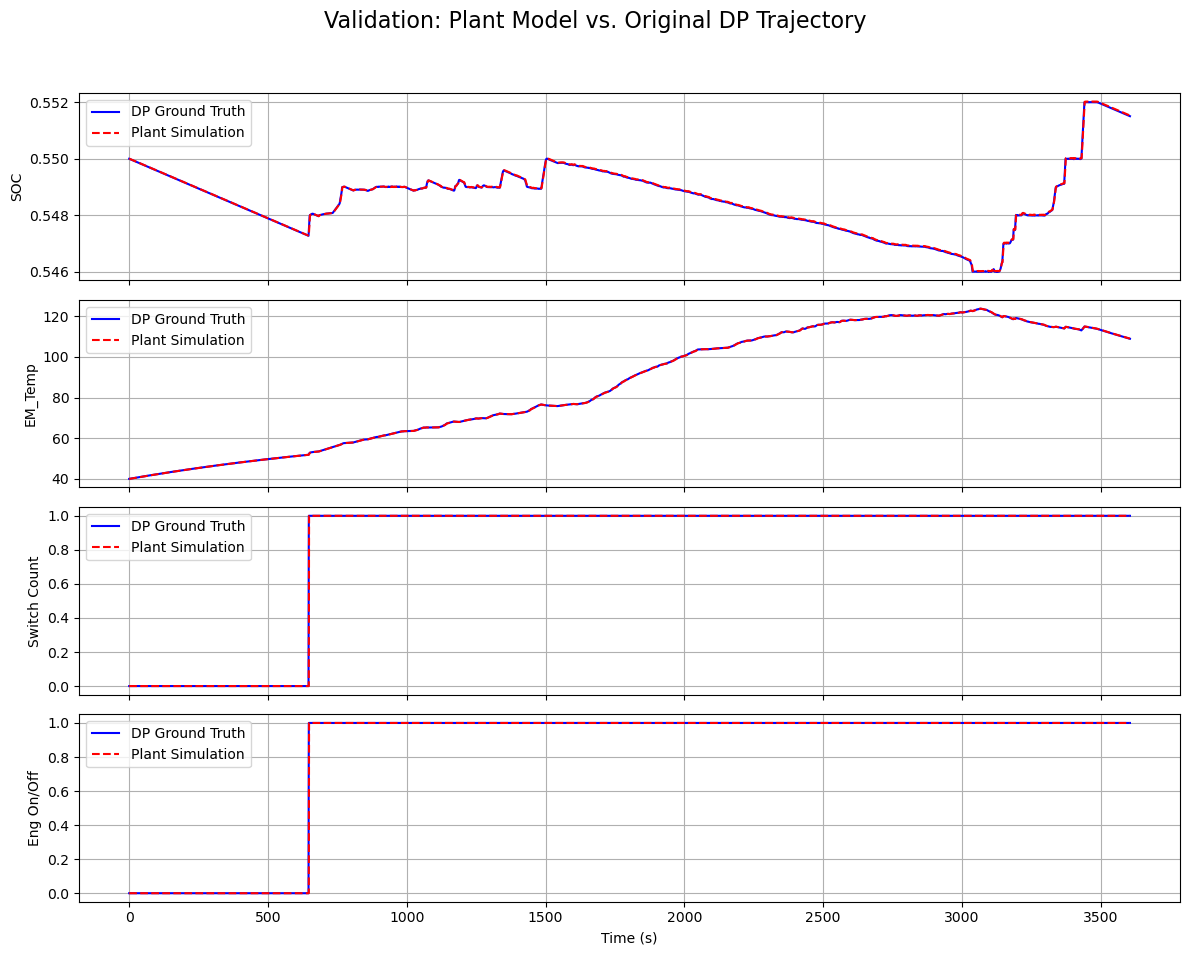


Total Reward from Expert Policy: -3878.70


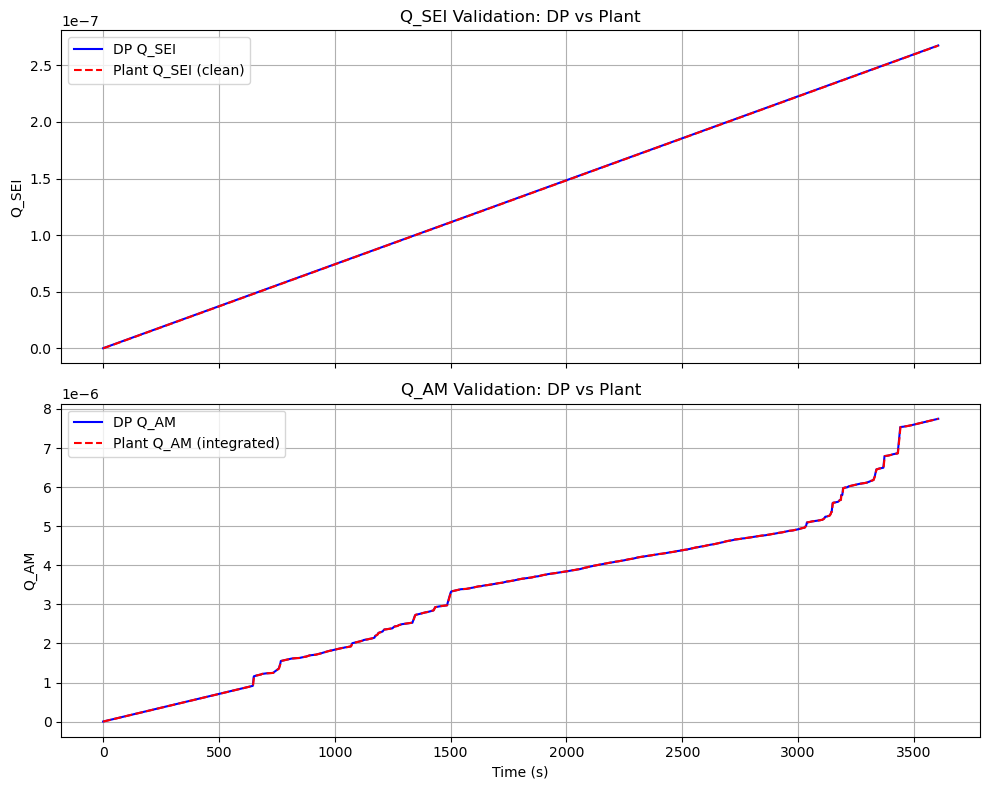

In [6]:
# Cell 5: Model Validation
# Run the environment for one full episode using the expert DP actions to verify its behavior.

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Initialize History Lists and Reset the Environment ---
states_hist = []  # sequence of standardized observations
rewards_hist = []

# ⭐ NEW: histories
Q_AM_sim  = [0.0]
Q_SEI_sim = [0.0]   # NEW: clean Q_SEI from plant (offset-free)

obs = env.reset()
states_hist.append(obs)
done = False

print("Running validation loop...")

# --- 2. Run the Simulation Loop with Expert Actions ---
for t in range(env.N):
    if done:
        break

    # Expert action
    expert_action_2d = dp_actions_new[t]
    power, label = expert_action_2d[0], expert_action_2d[1]
    agent_action_3d = np.array([
        power * label,
        1.0 - label,
        label
    ])

    # Step environment
    obs, reward, done, info = env.step(agent_action_3d)

    # Store
    states_hist.append(obs)
    rewards_hist.append(reward)

    # ⭐ Integrate Q_AM
    prev_Q_AM = Q_AM_sim[-1]
    Q_AM_next = prev_Q_AM + info["dQ_AM"] * sim.Ts
    Q_AM_sim.append(Q_AM_next)

    # ⭐ Store clean Q_SEI from plant (offset-free)
    Q_SEI_sim.append(info["Q_SEI"])

print("Validation loop complete.")

# --- 3. Process and De-standardize ---
states_hist_std = np.array(states_hist)
rewards_hist    = np.array(rewards_hist)

# De-standardize states (last 5 columns)
state_vars_std           = states_hist_std[:, 4:]
mean_states              = OBS_MEAN[4:]
std_states               = OBS_STD[4:]
states_de_standardized   = state_vars_std * std_states + mean_states

# But Q_SEI inside env obs is internal (biased). Replace with clean value:
states_de_standardized[:, 1] = np.array(Q_SEI_sim[:len(states_de_standardized)])

# DP states
dp_states = raw_obs[:, 4:]

# --- 4. Plot Comparison (WITHOUT Q_SEI) ---
time_steps = np.arange(len(states_de_standardized))

# Remove Q_SEI → only 4 plots now
state_names = ["SOC", "EM_Temp", "Switch Count", "Eng On/Off"]
state_indices = [0, 2, 3, 4]   # skip Q_SEI index 1

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Validation: Plant Model vs. Original DP Trajectory', fontsize=16)

for plot_i, state_idx in enumerate(state_indices):
    axs[plot_i].plot(time_steps, dp_states[:len(time_steps), state_idx],
                     'b-', label='DP Ground Truth')
    axs[plot_i].plot(time_steps, states_de_standardized[:, state_idx],
                     'r--', label='Plant Simulation')
    axs[plot_i].set_ylabel(state_names[plot_i])
    axs[plot_i].legend()
    axs[plot_i].grid(True)

axs[-1].set_xlabel("Time (s)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"\nTotal Reward from Expert Policy: {np.sum(rewards_hist):.2f}")

# =====================================================================
# ⭐ NEW: Combined Q_SEI + Q_AM Validation Figure
# =====================================================================

# DP Q_AM and Q_SEI from .mat
Q_AM_dp  = data['Q_AM'].flatten()
Q_SEI_dp = data['Q_SEI'].flatten()

# Align lengths
L = min(len(Q_AM_sim), len(Q_AM_dp), len(Q_SEI_sim), len(Q_SEI_dp))
t_q = np.arange(L)

Q_AM_dp_aligned   = Q_AM_dp[:L]
Q_AM_sim_aligned  = np.array(Q_AM_sim[:L])

Q_SEI_dp_aligned  = Q_SEI_dp[:L]
Q_SEI_sim_aligned = np.array(Q_SEI_sim[:L])

# --- Plot Q_SEI and Q_AM in two subplots ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Q_SEI
axs[0].plot(t_q, Q_SEI_dp_aligned,  'b-', label='DP Q_SEI')
axs[0].plot(t_q, Q_SEI_sim_aligned, 'r--', label='Plant Q_SEI (clean)')
axs[0].set_ylabel("Q_SEI")
axs[0].set_title("Q_SEI Validation: DP vs Plant")
axs[0].grid(True)
axs[0].legend()

# Q_AM
axs[1].plot(t_q, Q_AM_dp_aligned,  'b-', label='DP Q_AM')
axs[1].plot(t_q, Q_AM_sim_aligned, 'r--', label='Plant Q_AM (integrated)')
axs[1].set_ylabel("Q_AM")
axs[1].set_title("Q_AM Validation: DP vs Plant")
axs[1].set_xlabel("Time (s)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


In [7]:
# Cell 6: Transformer (PITM) model + scalers

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"     # Hide INFO + WARNING messages
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"     # Disable oneDNN to stop its warnings

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, TimeDistributed, Embedding, Lambda, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers, mixed_precision
from collections import deque
import joblib, json
import os

# -------------------------------
# 6.1 Mixed precision for speed
# -------------------------------
mixed_precision.set_global_policy('mixed_float16')
print("✅ Keras mixed precision policy set to 'mixed_float16'.")

# -------------------------------
# 6.2 Core hyperparameters
#    (must match training notebook)
# -------------------------------
EMBED_DIM       = 128
NUM_HEADS       = 4
FF_DIM          = 64
NUM_LAYERS      = 4
SOFTPLUS_BETA   = 1.0
GROUP_EMBED_DIM = 8
DROPOUT         = 0.20
L2_REG          = 5e-4
GAUSSIAN_NOISE_STDDEV = 0.001

WINDOW_SIZE = 150
NUM_GROUPS  = 1

# Used in inference (same as training)
T_MIN       = 273.15 + 10.0
T_MAX       = 273.15 + 50.0
SCALE_DELTA = 1e5

GROUP_CONFIG_FILE = "scalers/group_config.json"
DELTA_SCALER_NAME = "delta_scaler_D5_Cells_1.pkl"
MODEL_PATH        = "models/rs2_run10_best.h5"

# -------------------------------
# 6.3 Transformer building blocks
# -------------------------------
def transformer_encoder_prenorm(x, head_size, num_heads, ff_dim, dropout, l2_reg):
    x_ln1 = LayerNormalization(epsilon=1e-6)(x)
    attn  = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x_ln1, x_ln1)
    attn  = Dropout(dropout)(attn)
    x     = Add()([x, attn])

    x_ln2 = LayerNormalization(epsilon=1e-6)(x)
    ff    = Dense(ff_dim, activation="relu",
                  kernel_regularizer=regularizers.l2(l2_reg))(x_ln2)
    ff    = Dropout(dropout)(ff)
    ff    = Dense(x.shape[-1],
                  kernel_regularizer=regularizers.l2(l2_reg))(ff)
    x     = Add()([x, ff])
    return x

class SharedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.window_size   = int(window_size)
        self.embedding_dim = int(embedding_dim)
        self.embedding_layer = Embedding(
            input_dim=self.window_size,
            output_dim=self.embedding_dim,
            name="shared_pos_embedding"
        )

    def call(self, x):
        T = tf.shape(x)[1]
        positions = tf.range(start=0, limit=T, delta=1)
        pos_enc = self.embedding_layer(positions)
        pos_enc = tf.expand_dims(pos_enc, axis=0)
        pos_enc = tf.tile(pos_enc, [tf.shape(x)[0], 1, 1])
        pos_enc = tf.cast(pos_enc, x.dtype)
        return x + pos_enc

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "window_size": self.window_size,
            "embedding_dim": self.embedding_dim
        })
        return cfg

def softplus32(z, beta=1.0):
    z32   = tf.cast(z, tf.float32)
    out32 = tf.nn.softplus(beta * z32) / beta
    return tf.cast(out32, z.dtype)

def build_pitm_model(
    window_size,
    num_groups,
    group_embed_dim=GROUP_EMBED_DIM,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    l2_reg=L2_REG,
    noise_stddev=GAUSSIAN_NOISE_STDDEV
):
    head_size  = max(1, embed_dim // num_heads)

    dyn_in      = Input(shape=(window_size, 7), name="dyn_in")
    static_in   = Input(shape=(4,),             name="static_in")
    group_id_in = Input(shape=(1,),             name="group_id_in", dtype="int32")

    dyn_noised = GaussianNoise(noise_stddev, name="dyn_gaussian_noise")(dyn_in)
    dyn_proj   = TimeDistributed(
        Dense(
            embed_dim,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg)
        ),
        name="dyn_physics_projection"
    )(dyn_noised)

    # Group embedding is present, but not used to modulate in the single-group case
    group_embed = Embedding(
        input_dim=num_groups,
        output_dim=embed_dim,
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="group_embedding"
    )(group_id_in)

    dyn_modulated = dyn_proj  # single-group: no modulation

    shared_pos = SharedPositionalEncoding(window_size, embed_dim, name="shared_pos_enc")
    x = shared_pos(dyn_modulated)

    for _ in range(num_layers):
        x = transformer_encoder_prenorm(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            l2_reg=l2_reg
        )

    x_last = Lambda(lambda t: t[:, -1, :], name="take_last_token")(x)

    fused = x_last
    fused_head = Dense(
        64, activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused)
    fused_head = Dense(
        32, activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused_head)

    raw = Dense(
        1,
        name="raw_pre_softplus",
        bias_initializer=initializers.Constant(0.0),
        kernel_regularizer=regularizers.l2(l2_reg),
    )(fused_head)

    delta_hat = Lambda(
        lambda z: softplus32(z, beta=SOFTPLUS_BETA),
        name="delta_hat"
    )(raw)

    model = Model(
        inputs=[dyn_in, static_in, group_id_in],
        outputs=delta_hat,
        name="PITM_DeltaTransformer_v7_Modulated_SingleGroup"
    )
    return model

# -------------------------------
# 6.4 PercentileScaler stub
#     (needed only to load the saved scaler)
# -------------------------------
class PercentileScaler:
    def __init__(self, p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20):
        self.scale_ = 1.0
        self.clip_limit_ = 1e9
    def fit(self, x): pass
    def transform(self, x): return np.asarray(x).reshape(-1, 1) / self.scale_
    def inverse_transform(self, x): return np.asarray(x).reshape(-1, 1) * self.scale_

# -------------------------------
# 6.5 Build model + load weights
# -------------------------------
try:
    pitm_model = build_pitm_model(
        window_size=WINDOW_SIZE,
        num_groups=NUM_GROUPS
    )
    pitm_model.load_weights(MODEL_PATH)
    pitm_model.compile(optimizer='adam', loss='mse')
    print(f"✅ PITM model rebuilt and weights loaded from: {MODEL_PATH}")
except Exception as e:
    print(f"FATAL: error building/loading PITM model:\n{e}")
    pitm_model = None

# -------------------------------
# 6.6 Load scalers & config
# -------------------------------
try:
    feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
    static_scaler  = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
    delta_scaler_group = joblib.load(os.path.join("scalers", DELTA_SCALER_NAME))

    with open(os.path.join("scalers", "time_stats.json"), "r") as f:
        time_stats = json.load(f)
    P95_T  = float(time_stats["p95_t"])
    P95_DT = float(time_stats["p95_dt"])

    with open(GROUP_CONFIG_FILE, "r") as f:
        group_config = json.load(f)
    GROUP_ID = group_config["GROUP_ID"]

    print(f"✅ Scalers and config loaded. GROUP_ID = {GROUP_ID}")
except Exception as e:
    print(f"FATAL: error loading PITM scalers/config:\n{e}")
    feature_scaler = None
    static_scaler  = None
    delta_scaler_group = None
    P95_T, P95_DT = 1.0, 1.0
    GROUP_ID = 0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100S-PCIE-32GB, compute capability 7.0
✅ Keras mixed precision policy set to 'mixed_float16'.
✅ PITM model rebuilt and weights loaded from: models/rs2_run10_best.h5
✅ Scalers and config loaded. GROUP_ID = 0


In [8]:
# Cell 7: Static battery parameters + PITM buffers

# Reuse 'sim' from Cell 4
assert 'sim' in globals(), "HEVSimulator 'sim' must exist (run Cells 1–4 first)."

# --- Battery single-cell capacity (used for Q_total normalization & C-rate) ---
Bat_cap_cell = float(sim.BAT.Bat_cap)     # [Ah] per cell
Cap_Nom      = Bat_cap_cell               # PITM was trained with single-cell normalization

# For static inputs
V_MAX_CONST = 4.2
V_MIN_CONST = 2.8

# We'll compute the *actual* R_ch from the maps at runtime
r_dis_interp = sim.r_dis_interp
r_chg_interp = sim.r_chg_interp

# Window position feature (same as training)
WIN_POS_VEC = np.linspace(0, 1, WINDOW_SIZE, dtype=np.float32).reshape(WINDOW_SIZE, 1)

# PITM input buffers (raw, before feature_scaler)
buffer_SOC_raw      = deque(maxlen=WINDOW_SIZE)
buffer_V_raw        = deque(maxlen=WINDOW_SIZE)
buffer_T_raw        = deque(maxlen=WINDOW_SIZE)   # Kelvin
buffer_Crate_raw    = deque(maxlen=WINDOW_SIZE)
buffer_Time_s_raw   = deque(maxlen=WINDOW_SIZE)
buffer_Q_total_norm = deque(maxlen=WINDOW_SIZE)

print("✅ PITM buffers initialized.")


✅ PITM buffers initialized.


In [9]:
# Cell 8: Run PB-ROM + PITM simulation using HEVEnv + DP expert actions
DEBUG_PITM = True
DEBUG_T_STEPS = []    # will fill after N_steps is defined

from tqdm import tqdm
import os, joblib  # Load delta scaler

# Ensure sim and env exist
assert 'sim' in globals() and 'env' in globals(), "HEVSimulator 'sim' and HEVEnv 'env' must exist."

# --------------------------------------------------
# 8.0 Load PITM delta scaler for this group
# --------------------------------------------------
GROUP_NAME = "D5_Cells_1"
DELTA_SCALER_PATH = os.path.join("scalers", f"delta_scaler_{GROUP_NAME}.pkl")
delta_scaler_group = joblib.load(DELTA_SCALER_PATH)
print(f"✅ Loaded PITM delta scaler → {DELTA_SCALER_PATH}")

# --- ⚡ MINIMAL ADDITIONS: Tuning Parameters ⚡ ---
# 1. Noise Gate: Force tiny model noise (Softplus artifacts) to zero.
NOISE_GATE = 0 #1e-11 

# 2. Time Scaler: Adjusts magnitude if training dt != simulation dt (1.0s).
#    Keep at 1.0 initially. If estimation is still 10x too high, try 0.1.
TIME_SCALE_FACTOR = 0.065
# --------------------------------------------------

# --------------------------------------------------
# 8.1 Helpers + battery parameters
# --------------------------------------------------
BAT = sim.BAT
v0      = float(BAT.v0)
alpha0  = float(BAT.alpha0)
beta    = float(BAT.beta)
gamma_b = float(BAT.gamma)
zeta_b  = float(BAT.zeta)
epsilon = float(BAT.epsilon)
Ns      = float(BAT.Ns)
Np      = float(BAT.Np)

def compute_pack_ocv(SOC):
    v_cell = (
        v0
        + alpha0 * (1 - np.exp(-beta * SOC))
        + gamma_b * SOC
        + zeta_b * (1 - np.exp(-epsilon / (1 - SOC)))
    )
    return Ns * v_cell

def compute_pack_current(P_batt, SOC):
    V_oc = compute_pack_ocv(SOC)
    T_C = 25.0

    if P_batt >= 0:
        R_bat = sim.r_dis_interp([[T_C, SOC]]).item()
    else:
        R_bat = sim.r_chg_interp([[T_C, SOC]]).item()

    discriminant = max(V_oc**2 - 4 * R_bat * P_batt, 0.0)
    eta = 0.9
    Ib  = eta * (V_oc - np.sqrt(discriminant)) / (2 * R_bat)
    return np.clip(Ib, BAT.Ib_min, BAT.Ib_max), V_oc

# --------------------------------------------------
# 8.2 Simulation setup
# --------------------------------------------------
SOC_0   = init_state[0]
Q_SEI_0 = sim.Q_SEI_0
Gen_0   = init_state[2]
sw_0    = init_state[3]
eng_on0 = init_state[4]

SOC_sim         = [SOC_0]
Q_SEI_sim       = [Q_SEI_0]
Gen_temp_sim    = [Gen_0]
switch_sim      = [sw_0]
eng_on_sim      = [eng_on0]

Q_AM_sim        = [0.0]
Q_total_norm    = [0.0]

m_dot_fuel_sim  = []
Ib_sim          = [0.0]
V_sim           = [compute_pack_ocv(SOC_0)]

# ⭐ FIX: temperature is ALREADY IN K → DO NOT ADD 273.15
BAT_temp_sim    = [float(temp[0])]

Q_exp_pred_sim  = [0.0]
last_q_pred     = 0.0

# DP length
N_steps = min(raw_obs.shape[0], sim.N, dp_actions_new.shape[0])

# Define debug checkpoints
if DEBUG_PITM:
    DEBUG_T_STEPS = [WINDOW_SIZE,
                     min(WINDOW_SIZE + 1000, N_steps - 1),
                     N_steps - 1]

# --------------------------------------------------
# 8.3 Warm-up: env.reset()
# --------------------------------------------------
print("Resetting environment...")
obs_at_k1 = env.reset()
state_at_k1 = env.state

# Manually rerun k=0 step to get info
expert_action_k0 = dp_actions_new[0]
power_k0, label_k0 = expert_action_k0
action_k0 = np.array([power_k0 * label_k0, 1 - label_k0, label_k0])

inputs_k0 = raw_obs[0, :]
preq_k0   = inputs_k0[2]
gear_min, gear_max = N_gear
gear_norm_k0 = (inputs_k0[3] - gear_min) / (gear_max - gear_min)

_, _, _, _, _, _, _, _, _, _, out_k0, _ = sim.evaluate_step(
    0, init_state[0], init_state[1], init_state[2], init_state[3], init_state[4],
    action_k0[0], int(round(action_k0[2])), gear_norm_k0, preq_k0
)

# Append k=1 state
SOC_sim.append(state_at_k1[0])
# Q_SEI_sim.append(state_at_k1[1])
Q_SEI_sim.append(out_k0.Q_SEI)
Gen_temp_sim.append(state_at_k1[2])
switch_sim.append(state_at_k1[3])
eng_on_sim.append(state_at_k1[4])

# k=1 PB-ROM updates
Q_AM_next_k1 = Q_AM_sim[-1] + out_k0.dQ_AM * sim.Ts
Q_AM_sim.append(Q_AM_next_k1)

Ib_sim.append(out_k0.Ib_pack)
V_sim.append(out_k0.V_pack)

# ⭐ FIX: temp already Kelvin
BAT_temp_sim.append(float(temp[1]))

# PITM buffer for t=1
t_idx = 1
buffer_SOC_raw.append(SOC_sim[t_idx])

# ⭐ FIX: Use CELL VOLTAGE for PITM
V_cell_k1 = out_k0.V_pack / Ns
buffer_V_raw.append(V_cell_k1)

buffer_T_raw.append(BAT_temp_sim[t_idx])
buffer_Crate_raw.append(out_k0.Ib_cell / Bat_cap_cell)
buffer_Time_s_raw.append(t_idx * sim.Ts)

Q_total_next_norm_k1 = (Q_SEI_sim[t_idx] + Q_AM_sim[t_idx]) / Cap_Nom
buffer_Q_total_norm.append(Q_total_next_norm_k1)
Q_total_norm.append(Q_total_next_norm_k1)

print(f"Running PB-ROM + PITM simulation for {N_steps-1} steps...")
print(f"Warm-up window size = {WINDOW_SIZE}")

# --------------------------------------------------
# 8.4 Main simulation loop
# --------------------------------------------------
for t in tqdm(range(2, N_steps), desc="Sim + PITM"):

    if t >= dp_actions_new.shape[0]:
        break

    # Expert control
    power, label = dp_actions_new[t]
    action_3d = np.array([power * label, 1 - label, label])

    # Step environment
    obs_next, reward, done, info = env.step(action_3d)
    nxt = env.state

    # Q_SEI_next = nxt[1]
    Q_SEI_next = info["Q_SEI"]

    # Extract pack dynamics
    V_pack = info['V_pack']
    Ib_pack = info['Ib_pack']
    Ib_cell = info['Ib_cell']

    # ⭐ FIX: temperature already Kelvin — NO +273.15
    if t < temp.shape[0]:
        Tbat_K = float(temp[t])
    else:
        Tbat_K = BAT_temp_sim[-1]

    # PB-ROM state logging
    SOC_sim.append(nxt[0])
    Q_SEI_sim.append(Q_SEI_next)
    Gen_temp_sim.append(nxt[2])
    switch_sim.append(nxt[3])
    eng_on_sim.append(nxt[4])

    # Aging
    Q_AM_next = Q_AM_sim[-1] + info["dQ_AM"] * sim.Ts
    Q_total_next_norm = (Q_SEI_next + Q_AM_next) / Cap_Nom

    Q_AM_sim.append(Q_AM_next)
    Q_total_norm.append(Q_total_next_norm)

    # Other logs
    m_dot_fuel_sim.append(info['m_dot_fuel'])
    Ib_sim.append(Ib_pack)
    V_sim.append(V_pack)
    BAT_temp_sim.append(Tbat_K)

    # --------------------------------------------------
    # 5. PITM feature buffers
    # --------------------------------------------------
    buffer_SOC_raw.append(nxt[0])

    # ⭐ FIX: use CELL VOLTAGE
    V_cell = V_pack / Ns
    buffer_V_raw.append(V_cell)

    buffer_T_raw.append(Tbat_K)
    buffer_Crate_raw.append(Ib_cell / Bat_cap_cell)
    buffer_Time_s_raw.append(t * sim.Ts)
    buffer_Q_total_norm.append(Q_total_next_norm)

    # --------------------------------------------------
    # 6. PITM prediction
    # --------------------------------------------------
    if t >= WINDOW_SIZE:

        # Time normalization
        t_s = np.asarray(buffer_Time_s_raw)
        elapsed = t_s - t_s[0]
        dt = np.diff(t_s, prepend=t_s[0])
        t_abs_norm = np.clip(elapsed / max(P95_T, 1e-12), 0, 4)
        dt_norm    = np.clip(dt      / max(P95_DT,1e-12), 0, 4)

        # Voltage + temperature normalization
        V_arr = np.asarray(buffer_V_raw)
        T_arr = np.asarray(buffer_T_raw)

        V_norm = np.clip((V_arr - V_MIN_CONST) /
                         (V_MAX_CONST - V_MIN_CONST), -1, 2)
        T_norm = np.clip((T_arr - T_MIN) /
                         (T_MAX - T_MIN), -1, 2)

        rows6 = np.stack([buffer_SOC_raw, V_norm, T_norm,
                          t_abs_norm, dt_norm, buffer_Crate_raw], axis=1)

        rows7 = np.concatenate([rows6,
                                np.zeros((rows6.shape[0],1))], axis=1)

        rows_scaled = feature_scaler.transform(rows7).astype(np.float32)[:, :6]
        X_dyn = np.concatenate([rows_scaled, WIN_POS_VEC], axis=1).reshape(1,WINDOW_SIZE,7)

        # Static features
        if Ib_pack < 0:
            R_ch_now = r_chg_interp([[25.0, nxt[0]]]).item()
        else:
            R_ch_now = r_dis_interp([[25.0, nxt[0]]]).item()

        static_raw_vec = np.array([Bat_cap_cell, R_ch_now,
                                   V_MAX_CONST, V_MIN_CONST]).reshape(1,4)
        X_st = static_scaler.transform(static_raw_vec).astype(np.float32)

        X_gid = np.array([[GROUP_ID]], dtype=np.int32)

        # ---------- PITM forward ----------
        y_hat_scaled = pitm_model.predict([X_dyn, X_st, X_gid], verbose=0)[0,0]

        # ⭐ FIX: CORRECT UNSCALING & FILTERING
        y_hat_unscaled = delta_scaler_group.inverse_transform([[y_hat_scaled]])[0,0]
        
        # Calculate raw delta & APPLY TIME SCALER
        raw_delta = (y_hat_unscaled / SCALE_DELTA) * TIME_SCALE_FACTOR
        
        # --- ⚡ NOISE GATE ⚡ ---
        # If the predicted delta is extremely small (below noise floor), 
        # force it to zero to prevent "integration drift" of positive noise.
        if raw_delta < NOISE_GATE:
            dq_hat_delta = 0.0
        else:
            dq_hat_delta = raw_delta
        # ------------------------

        Q_prev = Q_exp_pred_sim[-1]
        Q_next = Q_prev + dq_hat_delta

        # monotonic
        Q_exp_pred_sim.append(max(Q_next, last_q_pred))
        last_q_pred = Q_exp_pred_sim[-1]
        
        # ---------- DEBUG ----------
        if DEBUG_PITM and t in DEBUG_T_STEPS:
            print("\n======= PITM DEBUG @ t =", t, "=======")
            print(f"Raw Unscaled Output: {y_hat_unscaled:.4e}")
            print(f"Raw Delta (Scaled): {raw_delta:.4e}")
            print(f"Gated Delta: {dq_hat_delta:.4e}")
            print(f"Total Q Accum: {last_q_pred:.4e}")

    else:
        Q_exp_pred_sim.append(Q_exp_pred_sim[-1])

    if done:
        break

print("✅ Simulation with env.step() and PITM complete.")

✅ Loaded PITM delta scaler → scalers/delta_scaler_D5_Cells_1.pkl
Resetting environment...
Running PB-ROM + PITM simulation for 3604 steps...
Warm-up window size = 150


Sim + PITM:   4%|▍         | 149/3603 [00:01<00:26, 129.69it/s]


======= PITM DEBUG @ t = 150 =======
Raw Unscaled Output: 1.1816e-03
Raw Delta (Scaled): 7.6804e-10
Gated Delta: 7.6804e-10
Total Q Accum: 7.6804e-10


Sim + PITM:  32%|███▏      | 1151/3603 [00:47<01:54, 21.38it/s]


======= PITM DEBUG @ t = 1150 =======
Raw Unscaled Output: 1.4753e-03
Raw Delta (Scaled): 9.5897e-10
Gated Delta: 9.5897e-10
Total Q Accum: 7.6065e-07


Sim + PITM: 100%|██████████| 3603/3603 [02:45<00:00, 21.82it/s]


======= PITM DEBUG @ t = 3604 =======
Raw Unscaled Output: 1.1749e-03
Raw Delta (Scaled): 7.6370e-10
Gated Delta: 7.6370e-10
Total Q Accum: 2.6553e-06
✅ Simulation with env.step() and PITM complete.


Cap_Nom_float used for percentage scaling: 4.85


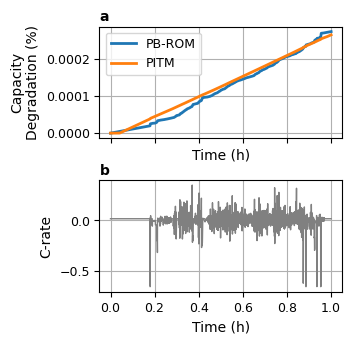

✅ Cell 9: percent plots saved to PITM_Simulator_Final_Degradation_percent.jpg


In [10]:
# Cell 9 — PITM vs PB-ROM vs DP (percentage, baseline-subtracted)

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Prepare / align arrays
# -----------------------------

# DP degradation (absolute Ah)
Q_SEI_dp = data['Q_SEI'].flatten()
Q_AM_dp = data['Q_AM'].flatten()
Q_total_dp_abs = Q_SEI_dp + Q_AM_dp           # Ah

# Plant degradation from PITM simulation loop (absolute Ah)
Q_total_sim_abs = np.array(Q_SEI_sim) + np.array(Q_AM_sim) # Ah
Q_pitm_abs = np.array(Q_exp_pred_sim) * Cap_Nom           # Ah

# --- CRITICAL FIX: Robust Alignment (Matching Cell 9.1 Logic) ---

# 1. Determine the length of the simulation data lists (includes k=0)
L_sim_data = len(Q_total_sim_abs)
L_dp_data = len(Q_total_dp_abs)

# 2. Determine the maximum common data index (DP length or SIM length - 1)
L_max_index = min(L_dp_data, L_sim_data - 1)

# Apply Slicing: Slice 1 element from the start of the Plant/PITM data lists (to remove k=0)
Q_total_sim_abs_ALIGNED = Q_total_sim_abs[1:L_max_index + 1] 
Q_pitm_abs_ALIGNED = Q_pitm_abs[1:L_max_index + 1] 

# Slice DP data to match the length L_max_index
Q_total_dp_abs_ALIGNED = Q_total_dp_abs[:L_max_index]

# 3. Final Check: Ensure all arrays are truly the minimum length
L_final = min(len(Q_total_dp_abs_ALIGNED), len(Q_total_sim_abs_ALIGNED), len(Q_pitm_abs_ALIGNED))

# --- Truncate all arrays to L_final ---
Q_total_dp_abs_ALIGNED = Q_total_dp_abs_ALIGNED[:L_final]
Q_total_sim_abs_ALIGNED = Q_total_sim_abs_ALIGNED[:L_final]
Q_pitm_abs_ALIGNED = Q_pitm_abs_ALIGNED[:L_final]

# Time array and current array must match L_final
t_hours = np.arange(L_final) * sim.Ts / 3600.0
Ib_aligned = np.array(Ib_sim)[1:L_max_index + 1][:L_final]


# -----------------------------
# 2) Baseline-subtract totals (relative growth)
# -----------------------------
# All arrays are now the same length (L_final) and aligned (k=1 start).
# Subtracting the first element zeros out the relative growth curve.
Q_total_dp_rel = Q_total_dp_abs_ALIGNED - Q_total_dp_abs_ALIGNED[0]
Q_total_sim_rel = Q_total_sim_abs_ALIGNED - Q_total_sim_abs_ALIGNED[0]
Q_pitm_rel = Q_pitm_abs_ALIGNED - Q_pitm_abs_ALIGNED[0]


# Convert to % of nominal capacity
Cap_Nom_float = float(Cap_Nom) # Ensure float division
Q_total_dp_pct = (Q_total_dp_rel / Cap_Nom_float) * 100.0
Q_total_sim_pct = (Q_total_sim_rel / Cap_Nom_float) * 100.0
Q_pitm_pct = (Q_pitm_rel / Cap_Nom_float) * 100.0

print(f"Cap_Nom_float used for percentage scaling: {Cap_Nom_float}")

# C-rate (from plant simulation)
Np = float(sim.BAT.Np)
# C-rate (from plant simulation) – pack → cell → C-rate
Crate_sim = Ib_aligned / (Np * Bat_cap_cell)

# Crate_sim = Ib_aligned / Bat_cap_cell # Using I_cell/Cap_cell definition


# -----------------------------
# 3) Plot
# -----------------------------
axis_fs = 10
tick_fs = 9
legend_fs = 9

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 3.5), sharex=True)
fig.tight_layout(pad=2.0)

# Top: capacity degradation %
# ax1.plot(t_hours, Q_total_dp_pct, label='DP ΔQ (%)', linewidth=2.0)
ax1.plot(t_hours, Q_total_sim_pct, label='PB-ROM', linewidth=2.0)
ax1.plot(t_hours, Q_pitm_pct, label='PITM', linewidth=2.0)

ax1.set_xlabel("Time (h)", fontsize=axis_fs)
ax1.set_ylabel("Capacity\nDegradation (%)", fontsize=axis_fs)
ax1.tick_params(axis='both', labelsize=tick_fs)
ax1.legend(fontsize=legend_fs, loc='upper left', frameon=True)
ax1.grid(True)
ax1.text(-0.0, 1.15, 'a', transform=ax1.transAxes, fontweight='bold', va='top')

# Bottom: C-rate
ax2.plot(t_hours, Crate_sim, color='gray', linewidth=1.0)
ax2.set_xlabel("Time (h)", fontsize=axis_fs)
ax2.set_ylabel("C-rate", fontsize=axis_fs)
ax2.tick_params(axis='both', labelsize=tick_fs)
ax2.grid(True)
ax2.text(-0.0, 1.15, 'b', transform=ax2.transAxes, fontweight='bold', va='top')

plt.show()

fig.savefig("PITM_Simulator_Final_Degradation_percent.jpg", dpi=600, format='jpeg')
print("✅ Cell 9: percent plots saved to PITM_Simulator_Final_Degradation_percent.jpg")

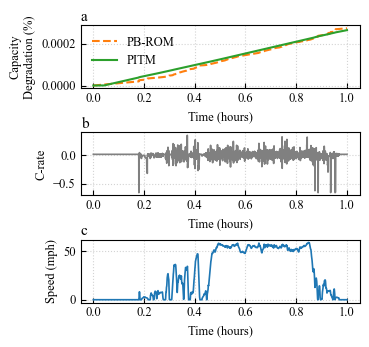

✅ Three-panel figure saved → PITM_with_Simulator.jpg


In [11]:
# Cell 10 — Final three-panel figure (Degradation %, C-rate, Velocity in mph)

import numpy as np
import matplotlib.pyplot as plt

# ---- Add Times New Roman font ----
from matplotlib import font_manager as fm
font_files = fm.findSystemFonts(fontpaths=['.'], fontext='ttf')
for f in font_files:
    fm.fontManager.addfont(f)

# ---- Global style (match Cell 2/3/4 nice plots) ----
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# ------------------------------------------------
# Convert DP speed from m/s → mph
# ------------------------------------------------
try:
    speed_mph = speed.flatten() * 2.23694
except:
    raise ValueError("Variable `speed` not found or incorrectly shaped.")

speed_mph_aligned = speed_mph[:len(t_hours)]

# ------------------------------------------------
# Plot settings
# ------------------------------------------------
axis_fs = 9
tick_fs = 9
legend_fs = 9

fig, axes = plt.subplots(3, 1, figsize=(3.6, 3.6), sharex=False)
plt.subplots_adjust(hspace=0.7)

# ------------------------------------------------
# (a) Capacity degradation %
# ------------------------------------------------
ax1 = axes[0]
ax1.plot(t_hours, Q_total_sim_pct, label='PB-ROM', linestyle='--', linewidth=1.5, color="#ff7f0e")   # orange
ax1.plot(t_hours, Q_pitm_pct,      label='PITM',   linewidth=1.5, color="#2ca02c")   # green

ax1.set_xlabel("Time (hours)", fontsize=axis_fs)
ax1.set_ylabel("Capacity\nDegradation (%)", fontsize=axis_fs)
ax1.tick_params(axis='both', labelsize=tick_fs)
ax1.legend(loc='upper left', frameon=False)
ax1.grid(True, linestyle=':', alpha=0.55)
ax1.text(0.00, 1.07, 'a', transform=ax1.transAxes, fontsize=11)

# ------------------------------------------------
# (b) C-rate
# ------------------------------------------------
ax2 = axes[1]
ax2.plot(t_hours, Crate_sim, color='gray', linewidth=1.2)

ax2.set_xlabel("Time (hours)", fontsize=axis_fs)
ax2.set_ylabel("C-rate", fontsize=axis_fs)
ax2.tick_params(axis='both', labelsize=tick_fs)
ax2.grid(True, linestyle=':', alpha=0.55)
ax2.text(0.00, 1.07, 'b', transform=ax2.transAxes, fontsize=11)

# ------------------------------------------------
# (c) Velocity (mph)
# ------------------------------------------------
ax3 = axes[2]
ax3.plot(t_hours, speed_mph_aligned, color="#1f77b4", linewidth=1.2)   # blue

ax3.set_xlabel("Time (hours)", fontsize=axis_fs)
ax3.set_ylabel("Speed (mph)", fontsize=axis_fs)
ax3.tick_params(axis='both', labelsize=tick_fs)
ax3.grid(True, linestyle=':', alpha=0.55)
ax3.text(0.00, 1.07, 'c', transform=ax3.transAxes, fontsize=11)

plt.show()

fig.savefig("PITM_with_Simulator_HHDDT.jpg",
            dpi=600, format='jpeg', bbox_inches='tight')

print("✅ Three-panel figure saved → PITM_with_Simulator.jpg")


In [12]:
# ================================================
# Cell 11 — Max Capacity Degradation (PB-ROM vs PITM)
# ================================================

import numpy as np

print("\n==============================")
print("   MAX CAPACITY DEGRADATION   ")
print("==============================\n")

# ---------------------------------------------
# Percentage degradation (%)
# ---------------------------------------------
max_pbrom_pct = float(np.max(Q_total_sim_pct))
max_pitm_pct  = float(np.max(Q_pitm_pct))

print(f"PB-ROM  max ΔQ (%):  {max_pbrom_pct:.6f} %")
print(f"PITM    max ΔQ (%):  {max_pitm_pct:.6f} %")

# ---------------------------------------------
# Absolute degradation (Ah)
# ---------------------------------------------
max_pbrom_Ah = float(np.max(Q_total_sim_abs_ALIGNED))
max_pitm_Ah  = float(np.max(Q_pitm_abs_ALIGNED))

print(f"\nPB-ROM  max ΔQ (Ah): {max_pbrom_Ah:.8e} Ah")
print(f"PITM    max ΔQ (Ah): {max_pitm_Ah:.8e} Ah")

print("\n============================================")
print("        END OF CAPACITY DEGRADATION REPORT   ")
print("============================================\n")



   MAX CAPACITY DEGRADATION   

PB-ROM  max ΔQ (%):  0.000274 %
PITM    max ΔQ (%):  0.000266 %

PB-ROM  max ΔQ (Ah): 1.33094494e-05 Ah
PITM    max ΔQ (Ah): 1.28783234e-05 Ah

        END OF CAPACITY DEGRADATION REPORT   



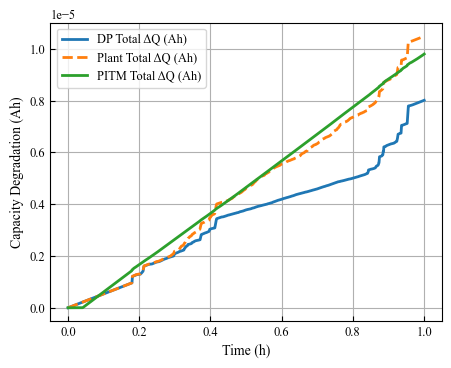

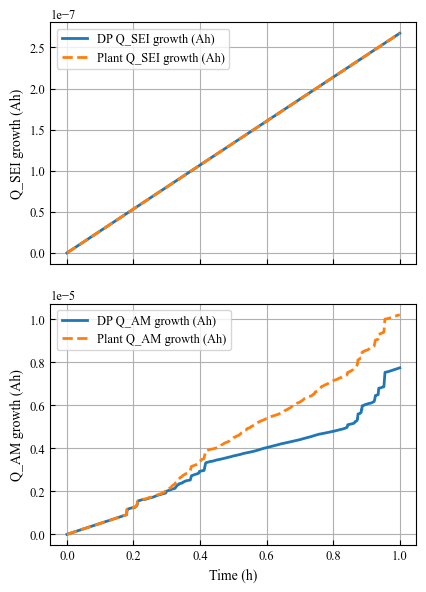

In [21]:
# Cell 9.1 — Absolute Ah plots (DP vs Plant vs PITM) + Q_SEI / Q_AM growth
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Prepare / align arrays
# ------------------------------------------------------------
Q_SEI_dp = data['Q_SEI'].flatten()
Q_AM_dp = data['Q_AM'].flatten()
Q_total_dp_abs = Q_SEI_dp + Q_AM_dp           # Ah

Q_total_sim_abs = np.array(Q_SEI_sim) + np.array(Q_AM_sim) # Ah
Q_pitm_abs = np.array(Q_exp_pred_sim) * Cap_Nom           # Ah

# --- CRITICAL FIX: Robust Alignment ---

# 1. Determine the length of the simulation data lists (includes k=0)
L_sim_data = len(Q_total_sim_abs)
L_dp_data = len(Q_total_dp_abs)

# 2. Determine the maximum common data index (DP length or SIM length - 1)
L_max_index = min(L_dp_data, L_sim_data - 1)

# Apply Slicing: Slice 1 element from the start of the Plant/PITM data lists (to remove k=0)
Q_total_sim_abs_ALIGNED = Q_total_sim_abs[1:L_max_index + 1] 
Q_pitm_abs_ALIGNED = Q_pitm_abs[1:L_max_index + 1] 

# Slice DP data to match the length L_max_index
Q_total_dp_abs_ALIGNED = Q_total_dp_abs[:L_max_index]

# 3. Final Check: Ensure all arrays are truly the minimum length
# This step accounts for any potential off-by-one error in the Q_pitm_abs list population in Cell 8.
L_final = min(len(Q_total_dp_abs_ALIGNED), len(Q_total_sim_abs_ALIGNED), len(Q_pitm_abs_ALIGNED))

# --- Truncate all arrays to L_final ---
Q_total_dp_abs_ALIGNED = Q_total_dp_abs_ALIGNED[:L_final]
Q_total_sim_abs_ALIGNED = Q_total_sim_abs_ALIGNED[:L_final]
Q_pitm_abs_ALIGNED = Q_pitm_abs_ALIGNED[:L_final]

t_hours = np.arange(L_final) * sim.Ts / 3600.0

# Prepare Q_SEI and Q_AM for component plot (slicing DP and Plant to L_final)
# Note: These components must also be truncated to L_final
Q_SEI_sim_ALIGNED = np.array(Q_SEI_sim)[1:L_max_index + 1][:L_final]
Q_AM_sim_ALIGNED = np.array(Q_AM_sim)[1:L_max_index + 1][:L_final]
Q_SEI_dp_ALIGNED = Q_SEI_dp[:L_final]
Q_AM_dp_ALIGNED = Q_AM_dp[:L_final]


# Baseline-subtract TOTALS so all start from 0 Ah degradation (Relative Growth)
Q_total_dp_rel_abs = Q_total_dp_abs_ALIGNED - Q_total_dp_abs_ALIGNED[0]
Q_total_sim_rel_abs = Q_total_sim_abs_ALIGNED - Q_total_sim_abs_ALIGNED[0]
Q_pitm_rel_abs = Q_pitm_abs_ALIGNED - Q_pitm_abs_ALIGNED[0]

# ------------------------------------------------------------
# 2) Total ΔQ in Ah (DP vs Plant vs PITM) - Relative Growth
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
fig.tight_layout()

ax.plot(t_hours, Q_total_dp_rel_abs, label='DP Total ΔQ (Ah)', linewidth=2)
ax.plot(t_hours, Q_total_sim_rel_abs, '--', label='Plant Total ΔQ (Ah)', linewidth=2)
ax.plot(t_hours, Q_pitm_rel_abs, label='PITM Total ΔQ (Ah)', linewidth=2)

ax.set_xlabel("Time (h)", fontsize=10)
ax.set_ylabel("Capacity Degradation (Ah)", fontsize=10)
ax.grid(True)
ax.legend(fontsize=9)

plt.show()

# ------------------------------------------------------------
# 3) Separate Q_SEI and Q_AM growth — MATCHING CELL 5 STYLE (Relative Growth)
# ------------------------------------------------------------

L_comp = L_final # Use the calculated common length
t_comp_hours = t_hours # Use the common time array

# Q_SEI (Relative Growth: Force start at 0 Ah)
# Subtracting the first element of the ALIGNED arrays
Q_SEI_dp_rel = Q_SEI_dp_ALIGNED - Q_SEI_dp_ALIGNED[0]
Q_SEI_sim_rel = Q_SEI_sim_ALIGNED - Q_SEI_sim_ALIGNED[0]

# Q_AM (Relative Growth: Force start at 0 Ah)
Q_AM_dp_rel = Q_AM_dp_ALIGNED - Q_AM_dp_ALIGNED[0]
Q_AM_sim_rel = Q_AM_sim_ALIGNED - Q_AM_sim_ALIGNED[0]

fig, axs = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
fig.tight_layout(pad=2)

# --- Q_SEI RELATIVE GROWTH ---
axs[0].plot(t_comp_hours, Q_SEI_dp_rel, label="DP Q_SEI growth (Ah)", linewidth=2)
axs[0].plot(t_comp_hours, Q_SEI_sim_rel, '--', label="Plant Q_SEI growth (Ah)", linewidth=2)
axs[0].set_ylabel("Q_SEI growth (Ah)")
axs[0].grid(True)
axs[0].legend(fontsize=9)

# --- Q_AM RELATIVE GROWTH ---
axs[1].plot(t_comp_hours, Q_AM_dp_rel, label="DP Q_AM growth (Ah)", linewidth=2)
axs[1].plot(t_comp_hours, Q_AM_sim_rel, '--', label="Plant Q_AM growth (Ah)", linewidth=2)
axs[1].set_ylabel("Q_AM growth (Ah)")
axs[1].set_xlabel("Time (h)")
axs[1].grid(True)
axs[1].legend(fontsize=9)

plt.show()

Using N_debug = 3605 steps for C-rate comparison.


/tmp/slurmtmp.42074665/ipykernel_2434518/1395343458.py:310: RuntimeWarning: divide by zero encountered in scalar divide
  Q_SEI_next = Q_SEI_k + (((self.k_SEI * np.exp(-self.E_SEI / (self.R_val * self.T_K)))**2) /



--- C-rate ranges ---
DP C_rate     : min=-0.6600, max= 0.3165
Plant C_rate  : min=-0.6603, max= 0.3165

--- Ratio (Plant / DP) on non-zero DP C-rate ---
min=-6.90, median= 1.00, max= 19.44


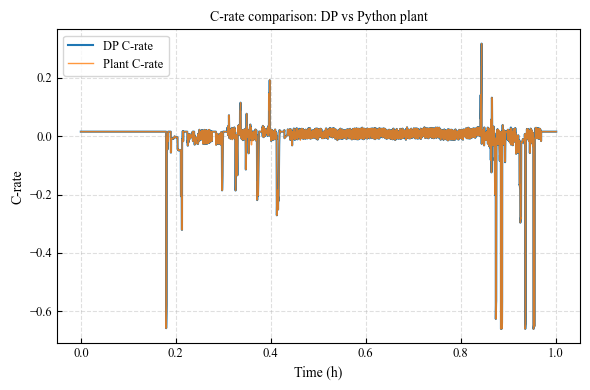

In [22]:
# ============================================
# Cell 9 — C-rate DEBUG: DP vs Python plant
# ============================================
import numpy as np
import matplotlib.pyplot as plt

# 1) Get DP Ib (pack current) from the loaded .mat file
if "Ib" not in data:
    raise KeyError("Could not find 'Ib' in `data`. Please check the variable name in your .mat file.")

Ib_dp = np.array(data["Ib"]).flatten()

# Make sure we don't exceed the shortest length
N_debug = min(N_steps, len(Ib_dp))
print(f"Using N_debug = {N_debug} steps for C-rate comparison.")

# 2) Pack → cell C-rate config (same for DP and plant)
BAT = sim.BAT
Bat_cap_cell = float(BAT.Bat_cap)   # [Ah] per cell
Np           = float(BAT.Np)        # number of parallel strings

# ✅ DP C-rate (reference) — same formula you described:
#    C_rate = Ib_pack / (Np * Bat_cap_cell)
C_rate_dp = Ib_dp[:N_debug] / (Np * Bat_cap_cell)

# 3) Re-run plant with DP actions and record C-rate
gear_min, gear_max = N_gear
C_rate_sim = []

# Start from the same initial state used elsewhere
SOC    = init_state[0]
Q_SEI  = sim.Q_SEI_0
Gen    = init_state[2]
sw     = init_state[3]
eng_on = init_state[4]

for k in range(N_debug):
    power_k, label_k = dp_actions_new[k]
    masked_power = power_k * label_k
    eng_cmd      = int(round(label_k))

    inputs_k  = raw_obs[k, :]
    preq_k    = inputs_k[2]
    gear_k    = inputs_k[3]
    gear_norm = (gear_k - gear_min) / (gear_max - gear_min)

    # ⚠️ Ensure SOC passed into evaluate_step is a scalar, not an array
    SOC_in = float(np.asarray(SOC).reshape(-1)[0])

    # One plant step with DP control
    (
        SOC_next, Q_SEI_next, Gen_next, sw_next, eng_on_next,
        SOC_min_viol, SOC_max_viol, Q_AM_viol,
        alpha_min_viol, alpha_max_viol,
        out_k, flag_k
    ) = sim.evaluate_step(
        k,
        SOC_in, Q_SEI, Gen, sw, eng_on,
        masked_power, eng_cmd, gear_norm, preq_k
    )

    # Pack-level current from plant
    Ib_pack_sim = out_k.Ib_pack

    # ✅ Use the SAME definition as DP:
    C_rate_k = Ib_pack_sim / (Np * Bat_cap_cell)
    C_rate_sim.append(C_rate_k)

    # Update states for next step
    SOC, Q_SEI, Gen, sw, eng_on = SOC_next, Q_SEI_next, Gen_next, sw_next, eng_on_next

C_rate_sim = np.array(C_rate_sim)

# 4) Print summary stats
print("\n--- C-rate ranges ---")
print(f"DP C_rate     : min={C_rate_dp.min(): .4f}, max={C_rate_dp.max(): .4f}")
print(f"Plant C_rate  : min={C_rate_sim.min(): .4f}, max={C_rate_sim.max(): .4f}")

# Ratios where DP C-rate is non-zero
mask = np.abs(C_rate_dp) > 1e-8
ratio = np.full_like(C_rate_dp, np.nan, dtype=float)
ratio[mask] = C_rate_sim[mask] / C_rate_dp[mask]

print("\n--- Ratio (Plant / DP) on non-zero DP C-rate ---")
print(f"min={np.nanmin(ratio): .2f}, median={np.nanmedian(ratio): .2f}, max={np.nanmax(ratio): .2f}")

# 5) Quick plot
t_hours = np.arange(N_debug) * sim.Ts / 3600.0

plt.figure(figsize=(6, 4))
plt.plot(t_hours, C_rate_dp,  label="DP C-rate",    linewidth=1.5)
plt.plot(t_hours, C_rate_sim, label="Plant C-rate", linewidth=1.0, alpha=0.8)
plt.xlabel("Time (h)")
plt.ylabel("C-rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.title("C-rate comparison: DP vs Python plant")
plt.tight_layout()
plt.show()
